### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Friday, Mar 27th at 11.59pm CST
---

In [99]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
import emcee
import acor
import corner
import dynesty
from dynesty import plotting as dyplot

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [2]:
data=np.load('../../homeworks/hw_data/hw5_data_1.npy')
print(np.shape(data))

(100, 3)


Text(0, 0.5, 'Flux')

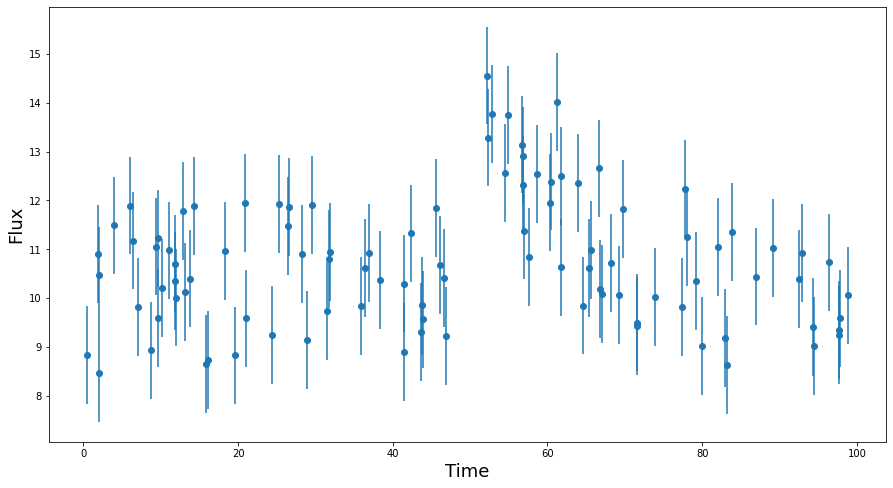

In [3]:
plt.errorbar(data[:,0],data[:,1],data[:,2],ls='none',marker='o')
plt.xlabel('Time',fontsize=18)
plt.ylabel('Flux',fontsize=18)

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

$${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - m_i)^2}{2\sigma_i^2}.$$

Where $x_i$ is a data point (in this case flux, not time), $m_i$ is the model, and $\sigma_i$ is the uncertainty

In [37]:
def burst_model(t,iniPar):
    # When t<t0, return b, else return b+a*exp[-alpha(t-t0)]
    t0=iniPar[0]
    b=iniPar[1]
    A=iniPar[2]
    alpha=iniPar[3]
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))

def burst_lnlikelihood(flux,model,sigma):
    numpoints=len(flux)
    lnlike=-np.sum([(flux[i]-model[i])**2/(2*sigma[i]**2) for i in range(numpoints)])
    return lnlike
    



SRT: Elegenat burst_model, very nice! However, your likelihood code would be faster if you got rid of that for-loop and just passed it arrays. -2

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [38]:
def uniform_lnprior(val,low,high):
    return np.where((val>low)&(val<high),0,-np.inf)

def burst_lnprior(iniPar):
    
    lnprior=0
    #t0
    lnprior+=uniform_lnprior(iniPar[0],low=0,high=100)
    #b
    lnprior+=uniform_lnprior(iniPar[1],low=0,high=50)
    #A
    lnprior+=uniform_lnprior(iniPar[2],low=0,high=50)
    #alpha
    lnprior+=uniform_lnprior(iniPar[3],low=np.exp(-5),high=np.exp(5))
    
    return lnprior

def mylnPosterior(iniPar,data):
    '''
    returns the log Posterior
    params:
        iniPar - initial parameter values for [t0,b,A,alpha]
        data - datacube with columns time,flux,uncertainty
    '''
    model=burst_model(data[:,0],iniPar)
    lnlike=burst_lnlikelihood(data[:,1],model,data[:,2])
    lnprior=burst_lnprior(iniPar)
    
    
    lnprob=lnprior+lnlike
    if np.isnan(lnprob):
        lnprob=-np.inf
    return lnprob
    

SRT: I don't think your prior for alpha is actually uniform in log-alpha. Also, technically while these are constant priors, these are not properly normalized for their ranges. -2 

### Try to get an initial guess for fit parameters

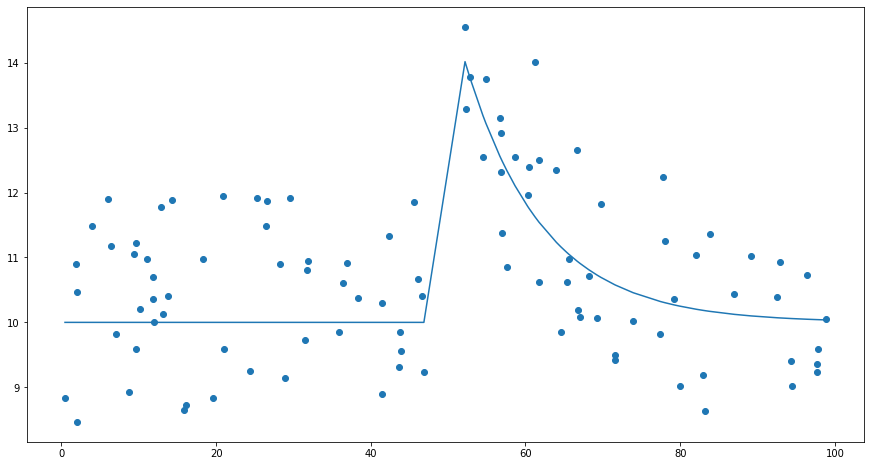

In [50]:
t0=50
b=10
A=5
alpha=0.1
iniPar=[t0,b,A,alpha]
model=burst_model(data[:,0],iniPar)
plt.scatter(data[:,0],data[:,1])
plt.plot(data[:,0],model)

In [56]:
ndim = 4  # number of parameters in the model
nwalkers = 25  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
# Use starting guess and add some uncertainty
starting_guesses = np.zeros(shape=(nwalkers,ndim))
for i in range(nwalkers):
    starting_guesses[i,:]=iniPar+0.2*np.random.random(size=ndim)
    

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, mylnPosterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

done


Text(0.5, 0, 'Step')

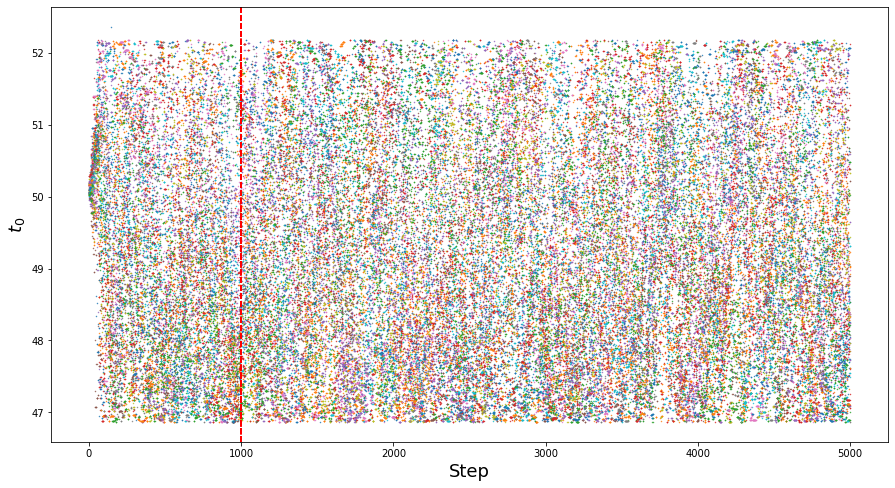

In [52]:
index=np.arange(nsteps-burn)
index_all=np.arange(nsteps)
for i in range(nwalkers):
    plt.scatter(index_all,sampler.chain[i,:,0],s=0.2)
    plt.axvline(burn,ls='--',c='r')
plt.ylabel('$t_0$',fontsize=18)
plt.xlabel('Step',fontsize=18)

Text(0.5, 0, 'Step')

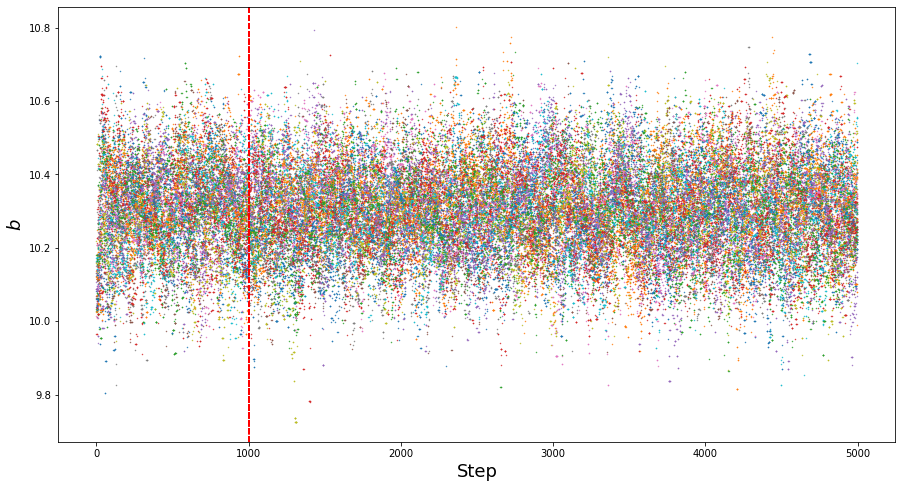

In [53]:
for i in range(nwalkers):
    plt.scatter(index_all,sampler.chain[i,:,1],s=0.2)
    plt.axvline(burn,ls='--',c='r')
plt.ylabel('$b$',fontsize=18)
plt.xlabel('Step',fontsize=18)

Text(0.5, 0, 'Step')

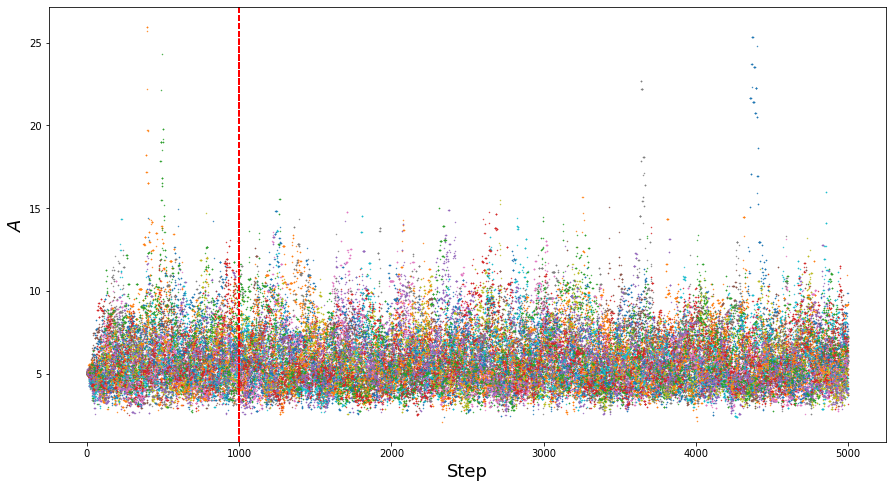

In [54]:
for i in range(nwalkers):
    plt.scatter(index_all,sampler.chain[i,:,2],s=0.2)
    plt.axvline(burn,ls='--',c='r')
plt.ylabel('$A$',fontsize=18)
plt.xlabel('Step',fontsize=18)

Text(0.5, 0, 'Step')

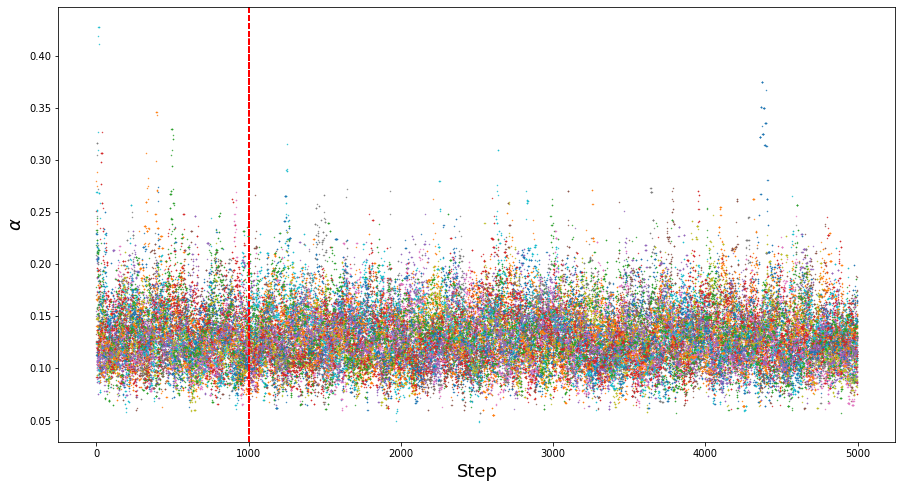

In [55]:
for i in range(nwalkers):
    plt.scatter(index_all,sampler.chain[i,:,3],s=0.2)
    plt.axvline(burn,ls='--',c='r')
plt.ylabel(r'$\alpha$',fontsize=18)
plt.xlabel('Step',fontsize=18)

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [65]:
thin = int(acor.acor(emcee_trace[:,0])[0])
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Number of Independent Samples: {:.0f}'.format(emcee_trace.shape[0]/thin))

Taking every n = 78 samples based on ac length.
Number of Independent Samples: 1282


Text(0, 0.5, '$t_0$')

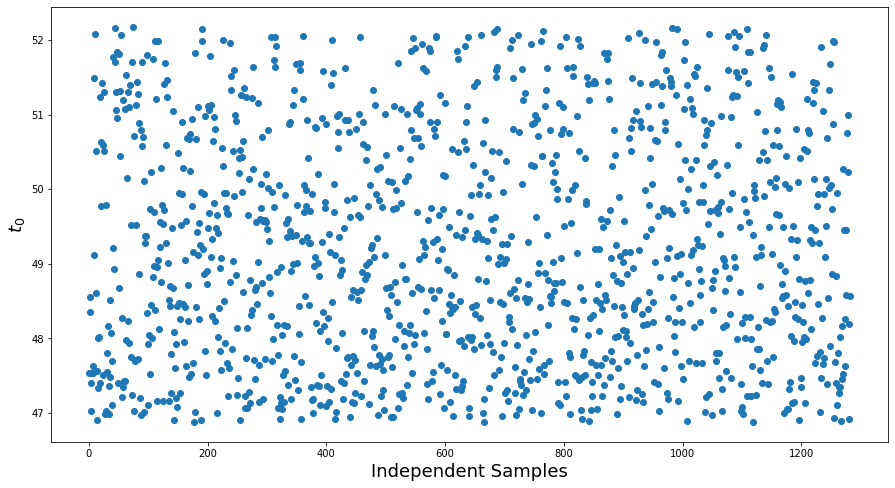

In [69]:
index=np.arange(np.shape(emcee_trace[::thin,0])[0])
plt.scatter(index,emcee_trace[::thin,0])
plt.xlabel('Independent Samples',fontsize=18)
plt.ylabel(r'$t_0$',fontsize=18)

Text(0, 0.5, '$b$')

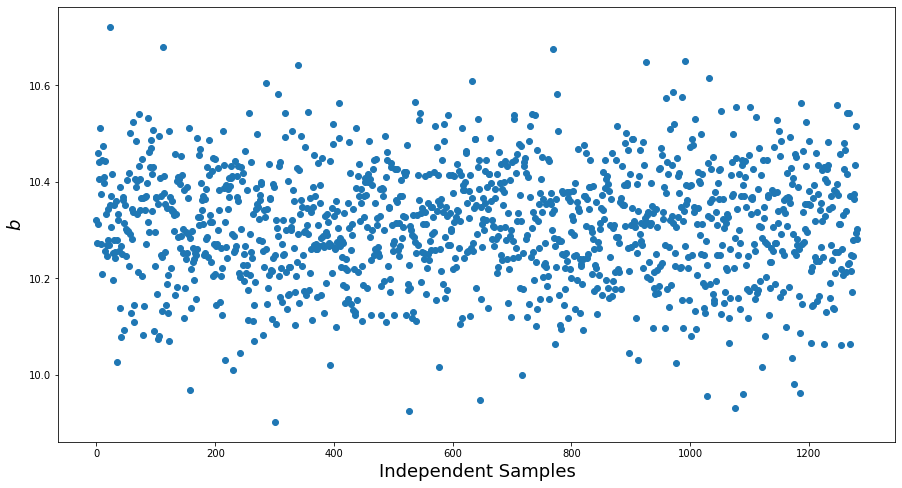

In [70]:
plt.scatter(index,emcee_trace[::thin,1])
plt.xlabel('Independent Samples',fontsize=18)
plt.ylabel(r'$b$',fontsize=18)

Text(0, 0.5, '$A$')

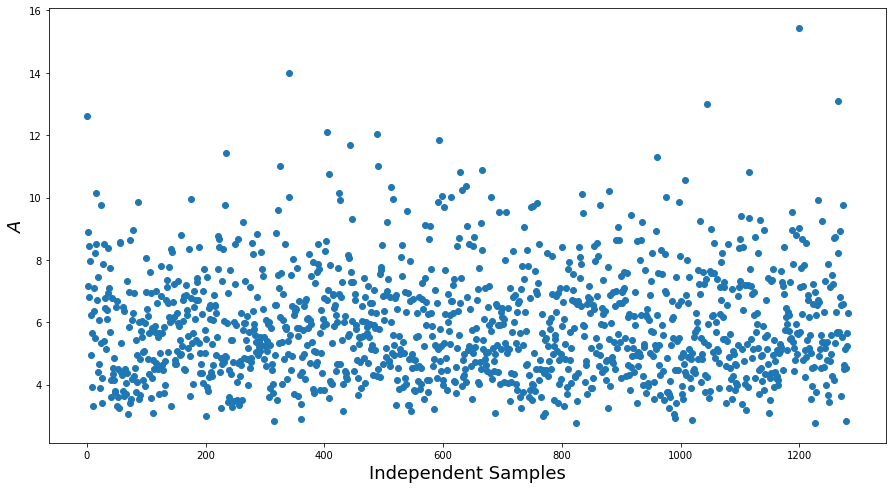

In [71]:
plt.scatter(index,emcee_trace[::thin,2])
plt.xlabel('Independent Samples',fontsize=18)
plt.ylabel(r'$A$',fontsize=18)

Text(0, 0.5, '$\\alpha$')

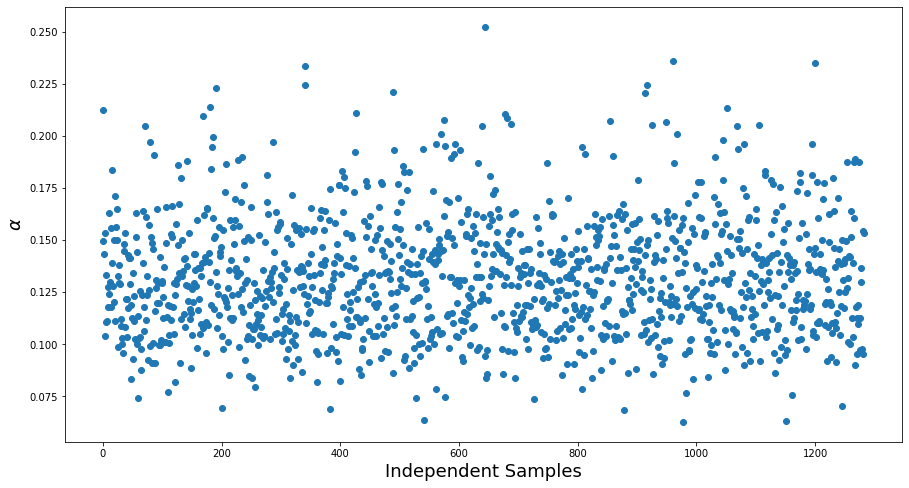

In [72]:
plt.scatter(index,emcee_trace[::thin,3])
plt.xlabel('Independent Samples',fontsize=18)
plt.ylabel(r'$\alpha$',fontsize=18)

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

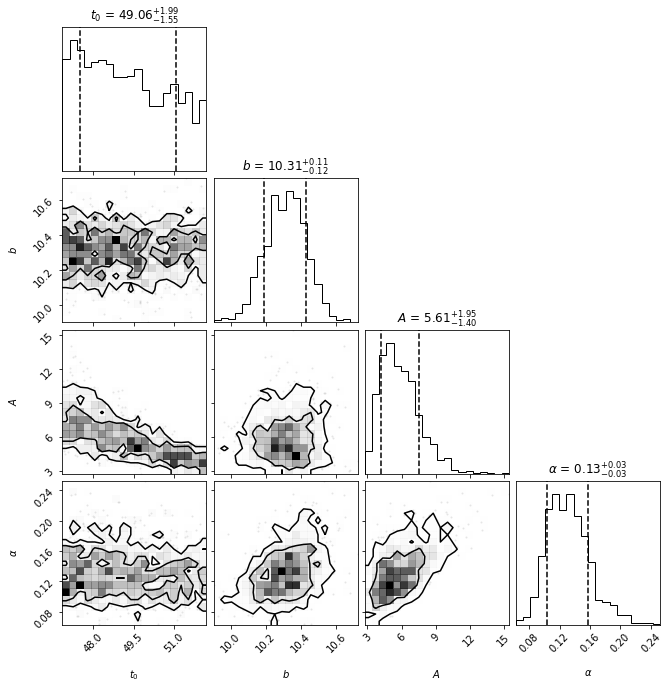

In [75]:
labels=[r'$t_0$',r'$b$',r'$A$',r'$\alpha$']

fig = corner.corner(emcee_trace[::thin,:], 
                    labels=labels,
                    quantiles=(0.16, 0.84),
                    levels=(0.68,0.95),
                    show_titles=True, 
                    title_kwargs={"fontsize": 12})

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

In [78]:
chain_burn_thin=emcee_trace[::thin,:]

#randomly choose 100 samples
idx_all=np.arange(chain_burn_thin.shape[0])
sample_idx=np.random.choice(idx_all,size=100)

samples=chain_burn_thin[sample_idx,:]

(100, 4)


Text(0, 0.5, 'Flux')

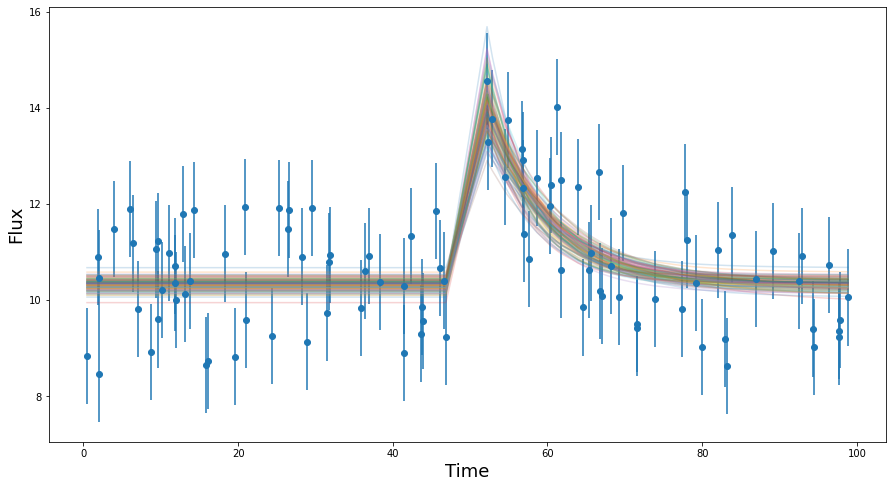

In [81]:
plt.errorbar(data[:,0],data[:,1],data[:,2],ls='none',marker='o')
for i in range(samples.shape[0]):
    iniPar=samples[i,:]
    model=burst_model(data[:,0],iniPar)
    plt.plot(data[:,0],model,alpha=0.2)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Flux',fontsize=18)
    

SRT: Very good!

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [120]:
# Original burst model

def resample(x,a,b):
    '''
    resamples x on Unif~[0,1) onto Unif~[a,b)
    '''
    return a+x*(b-a)
def ptform(u):
    '''
    transforms samples drawn from a unit hypercube to those from a uniform prior.
    u values are Unif~[0,1)
    
    u is a list of length ndim
    '''
    params=u.copy()
    
    # resample u[0]=t0 onto 0,100
    params[0]=resample(u[0],0,100)
    # resample u[1]=b onto 0,50
    params[1]=resample(u[1],0,50)
    # resample u[2]=A onto 0,50
    params[2]=resample(u[2],0,50)
    # resample u[3]=alpha onto exp(-5),exp(5)
    params[3]=resample(u[3],np.exp(-5),1)
    
    return params

def burst_loglike(iniPar):
    model=burst_model(data[:,0],iniPar)
    numpoints=data.shape[0]
    lnlike=-np.sum([(data[i,1]-model[i])**2/(2*data[i,2]**2) for i in range(numpoints)])
    
    if np.isnan(lnlike):
        return -np.inf
    return lnlike


SRT: Again, the uniform prior should be on the log of alpha, not alpha itself. I don't think the prior transform for alpha is correct. Let me know if I'm missing something here though. -1

In [121]:
# "Static" nested sampling.
ndim=4
sampler = dynesty.NestedSampler(burst_loglike, ptform, ndim)
sampler.run_nested()
burst_results = sampler.results

7408it [00:24, 298.23it/s, +500 | bound: 36 | nc: 1 | ncall: 44068 | eff(%): 17.945 | loglstar:   -inf < -48.767 <    inf | logz: -62.795 +/-  0.233 | dlogz:  0.001 >  0.509]


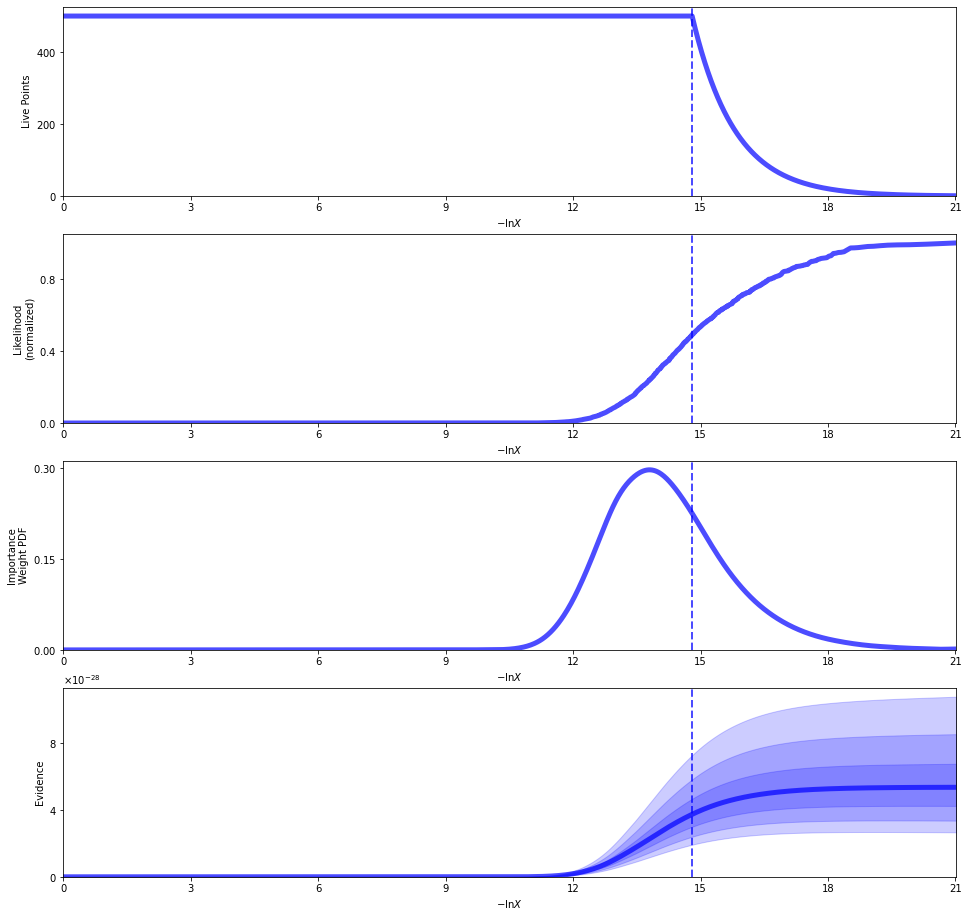

In [122]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(burst_results)

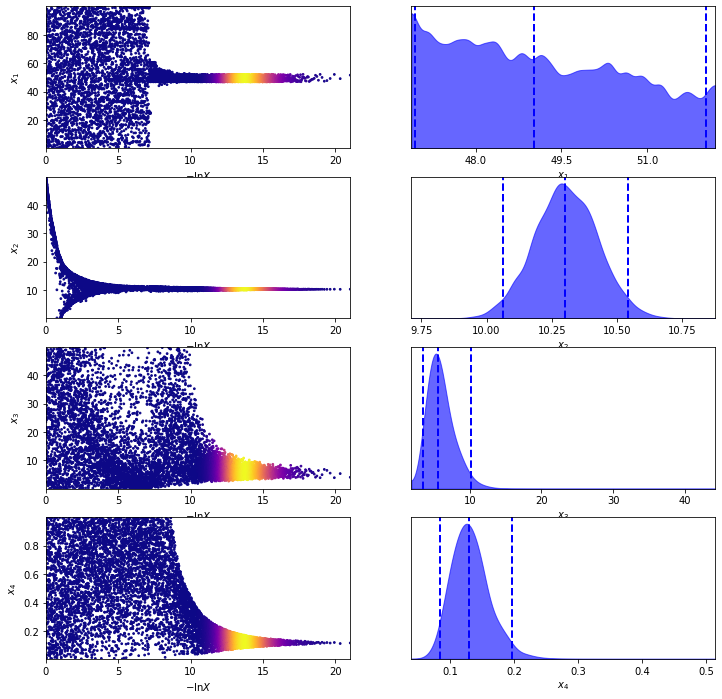

In [123]:
tfig, taxes = dyplot.traceplot(burst_results)

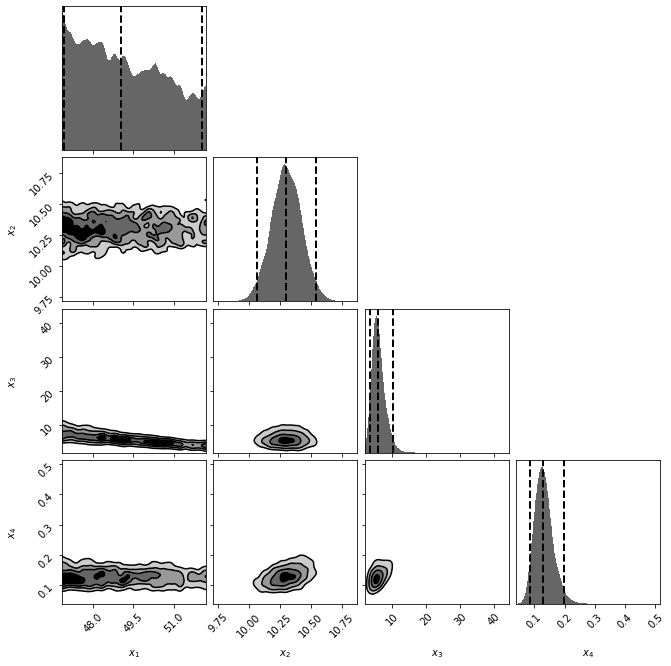

In [124]:
cfig, caxes = dyplot.cornerplot(burst_results)

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

In [131]:
# Gaussian Model 

def ptform(u):
    '''
    transform unit hypercube onto uniform priors
    '''
    params=u.copy()
    
    # resample u[0]=t0 onto 0,100
    params[0]=resample(u[0],0,100)
    # resample u[1]=b onto 0,50
    params[1]=resample(u[1],0,50)
    # resample u[2]=A onto 0,50
    params[2]=resample(u[2],0,50)
    # resample u[3]=sigma_w onto exp(-2),exp(2)
    params[3]=resample(u[3],np.exp(-2),np.exp(2))
    
    return params
def gauss_model(t,iniPar):
    '''
    here iniPar is [t0,b,A,sigma_w]
    '''
    t0=iniPar[0]
    b=iniPar[1]
    A=iniPar[2]
    sigma_w=iniPar[3]
    return b+A*np.exp(-(t-t0)**2/(2*sigma_w**2))
    
def gauss_loglike(iniPar):

    model=gauss_model(data[:,0],iniPar)
    numpoints=data.shape[0]
    lnlike=-np.sum([(data[i,1]-model[i])**2/(2*data[i,2]**2) for i in range(numpoints)])
    
    if np.isnan(lnlike):
        return -np.inf
    return lnlike

In [132]:
# "Static" nested sampling.
ndim=4
sampler = dynesty.NestedSampler(gauss_loglike, ptform, ndim)
sampler.run_nested()
gauss_results = sampler.results

7476it [00:17, 419.83it/s, +500 | bound: 25 | nc: 1 | ncall: 36592 | eff(%): 21.797 | loglstar:   -inf < -52.465 <    inf | logz: -66.675 +/-  0.237 | dlogz:  0.001 >  0.509]


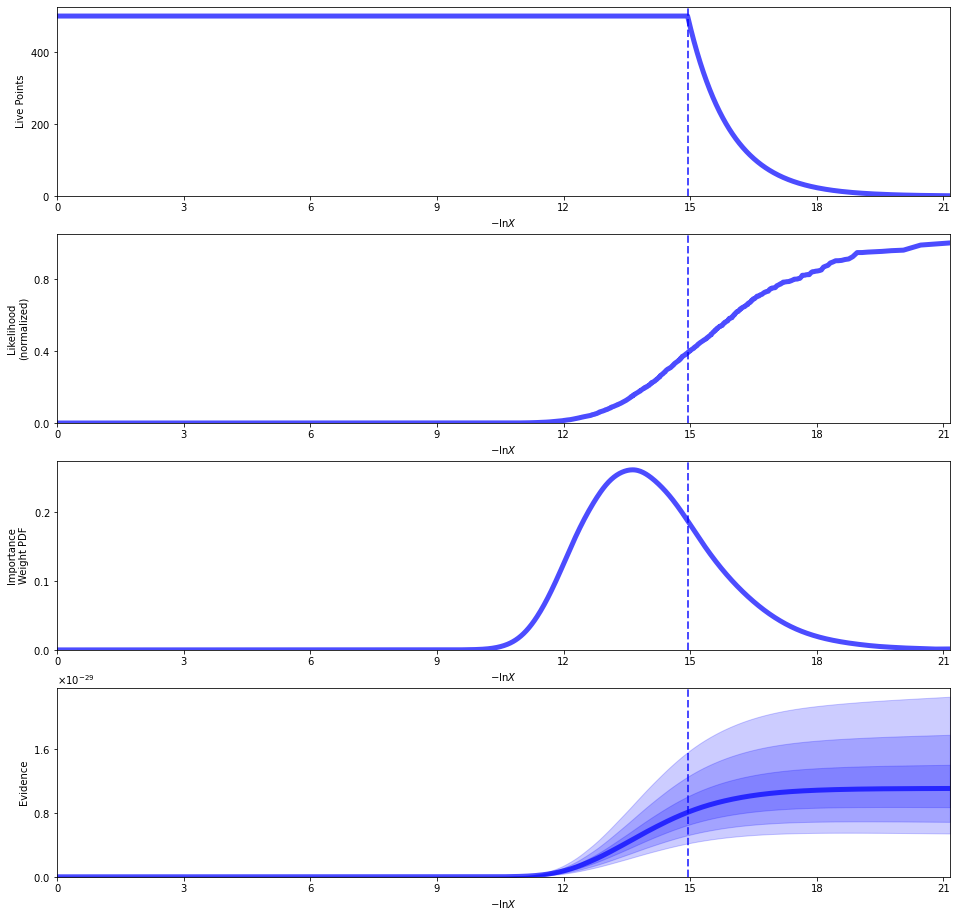

In [133]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(gauss_results)

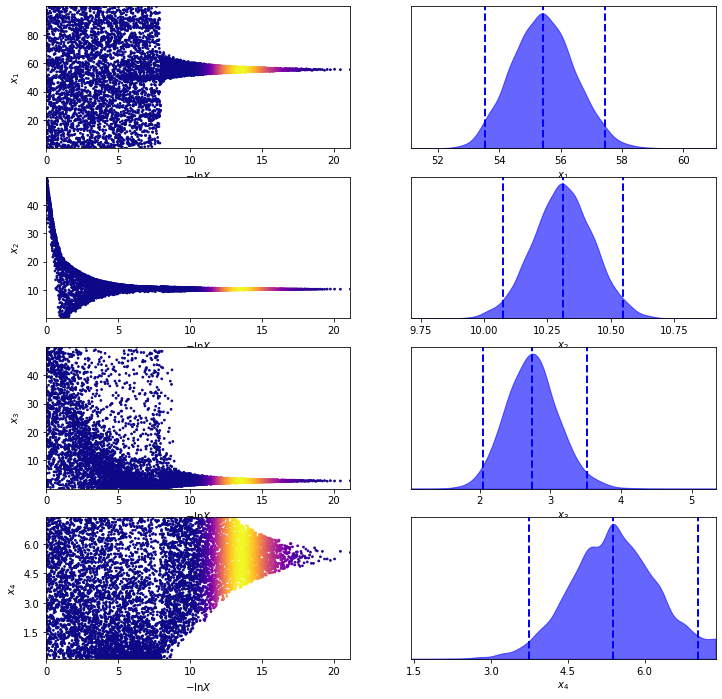

In [134]:
tfig, taxes = dyplot.traceplot(gauss_results)

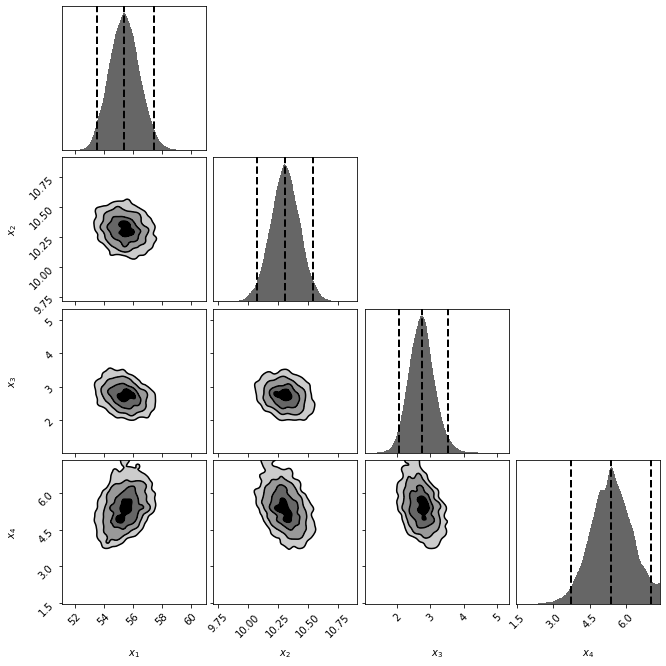

In [135]:
cfig, caxes = dyplot.cornerplot(gauss_results)

In [148]:
bayes_factor=np.exp(burst_results.logz[-1]-gauss_results.logz[-1])

print(bayes_factor)

48.43213888853132


### The sampler strongly prefers the burst model

SRT: Very good. I got a different numerical answer; more like 100. But this could be sampler choices, or more likely the fact that your prior was uniform in alpha rather than log-alpha.